In [1]:
import sys, os
import numpy as np
import time
import matplotlib.pyplot as plt
%matplotlib notebook
import tempfile

# this file should be run from {caffe_root}/examples (otherwise change this line)
caffe_root = '/media/hermetico/2TB/frameworks/caffe/' 
this_root = os.path.abspath('.')
alexnet_weights = os.path.join(caffe_root, 'models/bvlc_reference_caffenet/bvlc_reference_caffenet.caffemodel')

# main files for the network
activities_net_desc = {
    'weights': os.path.join(this_root,'models/finetuning-alexnet/reference_activitiesnet.caffemodel'),
    'train': os.path.join(this_root,'models/finetuning-alexnet/train-all-layers.prototxt'),
    'val': os.path.join(this_root,'models/finetuning-alexnet/val-all-layers.prototxt'), 
    'snapshot' :os.path.join(this_root,'models/finetuning-alexnet/finetune_dailyactivities')
}

sys.path.insert(0, caffe_root + 'python')
import caffe
caffe.set_device(0)
caffe.set_mode_gpu()


/home/hermetico/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/media/hermetico/2TB/frameworks/caffe/python/caffe/pycaffe.py:13: RuntimeWarning: to-Python converter for boost::shared_ptr<caffe::Net<float> > already registered; second conversion method ignored.
  from ._caffe import Net, SGDSolver, NesterovSolver, AdaGradSolver, \
/media/hermetico/2TB/frameworks/caffe/python/caffe/pycaffe.py:13: RuntimeWarning: to-Python converter for boost::shared_ptr<caffe::Blob<float> > already registered; second conversion method ignored.
  from ._caffe import Net, SGDSolver, NesterovSolver, AdaGradSolver, \
/media/hermetico/2TB/frameworks/caffe/python/caffe/pycaffe.py:13: RuntimeWarning: to-Python converter for boost::shared_ptr<caffe::Solver<float> > already registered; second conversion metho

Here we load the dataset files and parse the information, the image mean file is also loaded

In [2]:
# dataset stuff
train_dataset_path = os.path.join(caffe_root, 'data/daily_activities/train.txt')
val_dataset_path = os.path.join(caffe_root, 'data/daily_activities/val.txt')

train_dataset = [ line.split(' ') 
                for line in list(np.loadtxt(train_dataset_path, str, delimiter='\n'))
                if len(line.split(' ')) == 2 # there are some images with wierd paths
               ]
train_paths, train_labels = zip(*[(path, int(label)) for path, label in train_dataset])

val_dataset = [ line.split(' ') 
                for line in list(np.loadtxt(val_dataset_path, str, delimiter='\n'))
                if len(line.split(' ')) == 2 # there are some images with wierd paths
               ]
val_paths, val_labels = zip(*[(path, int(label)) for path, label in val_dataset])


# labels
labels_set = os.path.join(caffe_root, 'data/daily_activities/labels.txt')
labels_set = list(np.loadtxt(labels_set, str, delimiter='\n'))

# imagenet mean file
mean_file = os.path.join(caffe_root, 'data/ilsvrc12/imagenet_mean.binaryproto')

num_train_images = len(train_paths)
num_val_images = len(val_paths)
NUM_ACTIVITIES_LABELS = len(labels_set)
print 'Loaded labels:\n', ', '.join(labels_set)
print '\nTraining pictures', num_train_images
print '\nValidation pictures', num_val_images

Loaded labels:
Public transport, driving, walking outdoor, walking indoor, biking, having drinks with somebody, having drinks/meal alone, having meal with somebody, socializing, attending a seminar, meeting, reading, tv, cleaning and chores, working, cooking, shopping, talking, resting, mobile, Plane

Training pictures 13991

Validation pictures 1857


<IPython.core.display.Javascript object>


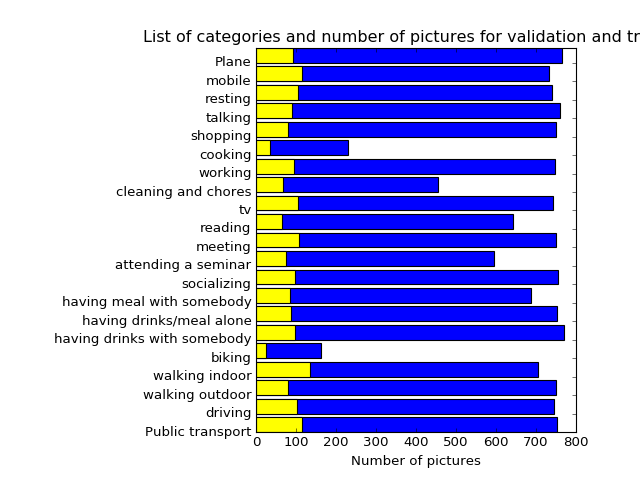

In [3]:
# train and val histogram
def plot_hist( set_labels , title='', color='blue'):
    import matplotlib.pyplot as plt
    plt.gcf().subplots_adjust(left=0.4)
    examples = [0] * NUM_ACTIVITIES_LABELS
    # each index index paths will contain a list of  pictures associated to a category
    for label in set_labels:
        examples[label] += 1

    y_pos = np.arange(NUM_ACTIVITIES_LABELS)
    num_examples = examples
    plt.barh(y_pos, num_examples,  alpha=1, color=color)
    plt.yticks(y_pos, labels_set)
    plt.xlabel('Number of pictures')
    plt.title('List of categories and number of pictures for validation and training')
    plt.show()
    
plot_hist(train_labels, 'Training')
plot_hist(val_labels, 'val', color='yellow')

Here we create a solver using the python API

In [13]:
from caffe.proto import caffe_pb2

def solver(
    train_net_path,
    validation_net_path=None,
    validation_interval=1000,
    base_lr=0.001, 
    iters=100000,
    snapshot_interval=5000, 
    lr_decay_interval=20000, 
    val_iterations = 1000,
    gamma=0.1,
    weight_decay=5e-4, 
    momentum=0.9,
    display=1000
    ):
    s = caffe_pb2.SolverParameter()

    # Specify locations of the train and (maybe) test networks.
    s.train_net = train_net_path
    if validation_net_path is not None:
        s.test_net.append(validation_net_path)
        s.test_interval = validation_interval  # Test after every 1000 training iterations.
        s.test_iter.append(val_iterations) 

    # The number of iterations over which to average the gradient.
    # Effectively boosts the training batch size by the given factor, without
    # affecting memory utilization.
    s.iter_size = 1
    
    s.max_iter = iters     # # of times to update the net (training iterations)
    
    # Solve using the stochastic gradient descent (SGD) algorithm.
    # Other choices include 'Adam' and 'RMSProp'.
    s.type = 'SGD'

    # Set the initial learning rate for SGD.
    s.base_lr = base_lr

    # Set `lr_policy` to define how the learning rate changes during training.
    # Here, we 'step' the learning rate by multiplying it by a factor `gamma`
    # every `stepsize` iterations.
    s.lr_policy = 'step'
    s.gamma = gamma
    s.stepsize = lr_decay_interval

    # Set other SGD hyperparameters. Setting a non-zero `momentum` takes a
    # weighted average of the current gradient and previous gradients to make
    # learning more stable. L2 weight decay regularizes learning, to help prevent
    # the model from overfitting.
    s.momentum = momentum
    s.weight_decay = weight_decay

    # Display the current training loss and accuracy every 1000 iterations.
    s.display = display

    # Snapshots are files used to store networks we've trained.  Here, we'll
    # snapshot every 10K iterations -- ten times during training.
    s.snapshot = snapshot_interval
    s.snapshot_prefix = activities_net_desc['snapshot']
    
    # Train on the GPU.  Using the CPU to train large networks is very slow.
    s.solver_mode = caffe_pb2.SolverParameter.GPU
    
    # Write the solver to a temporary file and return its filename.
    with tempfile.NamedTemporaryFile(delete=False) as f:
        f.write(str(s))
        return f.name

# stores the weights in a text file
def store_weights(weights):
    data = open(weights).read()
    with open(activities_net_desc['weights'], 'w') as f:
        f.write(data)
    

This function will run the solver and show plots with information regarding the training process

In [14]:
def run_solvers(niter, solver_data, disp_interval=10, validation_interval=1000):
    # keep track of the data
    types = ('loss', 'acc')
    data = { t: np.zeros(niter) for t in types }
    val_types = ('loss', 'acc', 'top-2', 'top-5')
    validation = { t: np.zeros(niter) for t in val_types }
    #test = {'loss':0, 'acc':0, 'top-2':0, 'top-5':0}
   
    fig, ax1 = plt.subplots(figsize=(10,7))
    ax2 = ax1.twinx()
    ax1.set_xlabel('iteration')
    ax1.set_ylabel('Loss')
    ax2.set_ylabel('Accuracy')
    
    plot_niter = [0]
    plot_val_niter = [0]
    plot_train_loss = [0]
    plot_train_accuracy = [0]
    plot_val_loss = [0]
    plot_val_accuracy = [0]
    plot_val_top_2 = [0]
    plot_val_top_5 = [0]
    

    a, = ax1.plot(plot_niter, plot_train_loss, 'blue', label='train loss')
    
    b, = ax1.plot(plot_val_niter, plot_val_loss, 'red', label='val loss')
    c, = ax2.plot(plot_val_niter, plot_val_accuracy, 'green', label='val Acc')
    d, = ax2.plot(plot_val_niter, plot_val_top_2, 'yellow', label='Top 2')
    e, = ax2.plot(plot_val_niter, plot_val_top_5, 'grey', label='Top 5')
    
    plt.legend(handles=[a, b, c, d,e],bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=3, mode="expand", borderaxespad=0.)
    
    
    name, s = solver_data
    for iteration in range(niter):
        s.step(1)  # run a single SGD step in Caffe
        #s.step(batch_size)  # run a single SGD step in Caffe
        
        for t in types:
            data[t][iteration] = s.net.blobs[t].data.copy()
            
        if iteration % disp_interval == 0 or iteration % validation_interval == 0: # interval step and last step
            loss = data['loss'][iteration]
            acc = data['acc'][iteration]
            ## plot
            plot_niter.append(iteration)
            plot_train_loss.append(loss)
            plot_train_accuracy.append(acc)
            
            ax1.plot(plot_niter, plot_train_loss, 'blue', label='train loss')
            #ax2.plot(plot_niter, plot_train_accuracy, 'red', label='train Acc')

            
            # validation
            if iteration % validation_interval == 0:
                loss_acc = 'loss=%.3f, acc=%.3f' % (loss, acc)
                output = '%3d)\ttrain %s:  %s' %(iteration, name, loss_acc)
                print output                

                for t in val_types:
                    validation[t][iteration] = s.test_nets[0].blobs[t].data.copy()
                    
                loss = validation['loss'][iteration]
                acc = validation['acc'][iteration]
                top_2 = validation['top-2'][iteration]
                top_5 = validation['top-5'][iteration]
                
                plot_val_niter.append(iteration)
                plot_val_loss.append(loss)
                plot_val_accuracy.append(acc)
                plot_val_top_2.append(top_2)
                plot_val_top_5.append(top_5)
                
                ax1.plot(plot_val_niter, plot_val_loss, 'red', label='val loss')
                ax2.plot(plot_val_niter, plot_val_accuracy, 'green', label='val acc')
                ax2.plot(plot_val_niter, plot_val_top_2, 'yellow', label='Top 2')
                ax2.plot(plot_val_niter, plot_val_top_5, 'grey', label='Top 5')
                
                loss_acc = 'loss=%.3f, acc=%.3f' % (loss, acc)
                output = '\tval %s:  %s' %(name, loss_acc)
                print output
            
            fig.canvas.draw()
        
    # Save the learned weights
    weight_dir = tempfile.mkdtemp()
    
    filename = 'weights.%s.caffemodel' % name
    weights = os.path.join(weight_dir, filename)
    s.net.save(weights)
    return data, weights



Here we define the hypterparameters that are going to be used in the solver

In [15]:
"""
# hyper
num_train = num_train_images
num_epochs = 20
batch_size = 64
iters_per_epoch = num_train_images / batch_size
niter = num_epochs * iters_per_epoch 
base_lr = 0.001
val_interval = iters_per_epoch /2
display_interval = 10
decay_interval = iters_per_epoch * 5 # each 5 epochs
snapshot_interval = iters_per_epoch * 10 # each 5 epochs
print num_train, iters_per_epoch, niter, val_interval, display_interval
"""


# We are going to train 10 epochs, which means that we are going to go through our dataset 20 times
num_train = num_train_images
num_val = num_val_images
num_epochs = 10
# if the model doesn't fit in GPU memory, try to reduce the batch size to 24. 
# that needs to be changed in train_val.prototxt too
batch_size = 64 # here only to calculate iterations, mofify also in tran and val
iters_per_epoch = num_train_images / batch_size # iterations for an epoch
iters_per_val = num_val_images / batch_size 


### solver data definition

solver_data = {}
solver_data['val_iter'] = 20           # num of iterations for the validation
solver_data['val_interval'] = iters_per_epoch / 5                      # we are going to validate twice per epoch
solver_data['base_lr'] = 0.00003                         # initial learning rate
solver_data['display_interval'] = 10
solver_data['num_iter'] = num_epochs * iters_per_epoch # total iterations
solver_data['drop_rate'] = 0.1
solver_data['drop_lr_step'] = 5 * iters_per_epoch      # The learning rate will decrease each 5 epochs
solver_data['snapshot'] = iters_per_epoch * 10 # each 5 epochs
solver_data['weight_decay'] = 0.005
solver_data['momentum'] = 0.9
    

#### SOLVER DEFINITION
solver_content = """test_iter: %(val_iter)i
test_interval: %(val_interval)i
base_lr: %(base_lr).5f
display: %(display_interval)i
max_iter: %(num_iter)i
lr_policy: "step"
gamma: %(drop_rate).5f
momentum: %(momentum).5f
weight_decay: %(weight_decay).5f
stepsize: %(drop_lr_step)i
snapshot: %(snapshot)i
snapshot_prefix: "snapshot"
solver_mode: GPU
solver_type: SGD""" % (solver_data)
print "This is the solver that is going to be used:"
print solver_content






This is the solver that is going to be used:
test_iter: 20
test_interval: 43
base_lr: 0.00003
display: 10
max_iter: 2180
lr_policy: "step"
gamma: 0.10000
momentum: 0.90000
weight_decay: 0.00500
stepsize: 1090
snapshot: 2180
snapshot_prefix: "snapshot"
solver_mode: GPU
solver_type: SGD


Running solver for 2180 iterations...


<IPython.core.display.Javascript object>


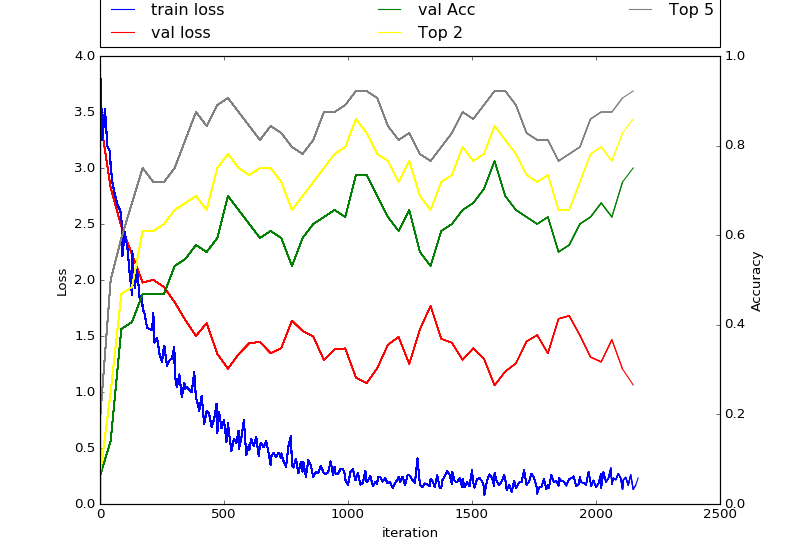

  0)	train finetuning:  loss=3.917, acc=0.031
	val finetuning:  loss=3.453, acc=0.062
 43)	train finetuning:  loss=3.014, acc=0.094
	val finetuning:  loss=2.823, acc=0.141
 86)	train finetuning:  loss=2.573, acc=0.203
	val finetuning:  loss=2.478, acc=0.391
129)	train finetuning:  loss=1.870, acc=0.406
	val finetuning:  loss=2.230, acc=0.406
172)	train finetuning:  loss=1.741, acc=0.562
	val finetuning:  loss=1.977, acc=0.469
215)	train finetuning:  loss=1.705, acc=0.484
	val finetuning:  loss=2.001, acc=0.469
258)	train finetuning:  loss=1.409, acc=0.594
	val finetuning:  loss=1.937, acc=0.469
301)	train finetuning:  loss=1.161, acc=0.688
	val finetuning:  loss=1.802, acc=0.531
344)	train finetuning:  loss=1.030, acc=0.703
	val finetuning:  loss=1.642, acc=0.547
387)	train finetuning:  loss=0.936, acc=0.750
	val finetuning:  loss=1.500, acc=0.578
430)	train finetuning:  loss=0.832, acc=0.766
	val finetuning:  loss=1.615, acc=0.562
473)	train finetuning:  loss=0.635, acc=0.812
	val fin

In [16]:
# NORMAL TRAINING WITH VALIDATION SET
end_to_end_net = activities_net_desc['train']
validation_end_to_end = activities_net_desc['val']


activities_solver_filename = solver(end_to_end_net, validation_end_to_end, 
                                    validation_interval=solver_data['val_interval'],
                                    base_lr=solver_data['base_lr'],
                                    iters=solver_data['num_iter'],
                                    snapshot_interval=solver_data['snapshot'],
                                    lr_decay_interval=solver_data['drop_lr_step'], 
                                    val_iterations = solver_data['val_iter'],
                                    gamma=solver_data['drop_rate'],
                                    weight_decay=solver_data['weight_decay'], 
                                    momentum=solver_data['momentum'],
                                    display=solver_data['display_interval']
                                   )


activities_solver = caffe.get_solver(activities_solver_filename)
activities_solver.net.copy_from(alexnet_weights)

print 'Running solver for %d iterations...' % solver_data['num_iter']

solver_desc = ('finetuning', activities_solver)

init = time.clock()

# runs the solver
data,  finetuning_weights = run_solvers(
    solver_data['num_iter'], 
    solver_desc, 
    solver_data['display_interval'], 
    solver_data['val_interval'])

end = time.clock() - init
print "Traning done in %2.f s" %(end)

# deleting stuff to save memory
del activities_solver, solver_desc


store_weights(finetuning_weights)
